# Solving a problem with quantum computers
Generating random numbers from a variety of specific probability distributions is interesting, but not enough to justify the hype around quantum computers. Let's now take an example of something where quantum computers can outperform digital computers. It's known as Grover's algorith, and allows a quantum computer to quickly figure out how an arbitrary "search" function behaves, where a digital computer would need to brute-force this and potentially try every possibility in turn.

First, we need to introduce a few new operations. 

https://en.wikipedia.org/wiki/Grover%27s_algorithm
https://www.ictp-saifr.org/wp-content/uploads/2022/11/ICTP_SAIFR_D1-L2.pdf
https://qiskit.org/ecosystem/algorithms/tutorials/06_grover.html
https://learn.qiskit.org/course/ch-algorithms/grovers-algorithm

### Z operation
The Z operation works on all pairs of rows in the state vector associated with different values of a particular qubit, and flips the sign on the second row of each pair. We can call it the "flip" gate. Let's have a quick look at an example.

If we start with an H(0) operator and an H(1) operator, as we did in the first notebook, we have the same value on each row of the state vector. If we then do a Z(0) follwed by a Z(1), you can see the signs flip but the numbers otherwise stay the same.
| Qubits| Initial state vector | H(0) | H(1) | Z(0) | Z(1) |
| :- | :- | :- | :- | :- | :- |
| $|00\rangle$ | $1.0$ | $\frac{1}{\sqrt{2}}$ | $\frac{1}{2}$ | $\frac{1}{2}$  | $\frac{1}{2}$  |
| $|01\rangle$ | $0.0$ | $\frac{1}{\sqrt{2}}$ | $\frac{1}{2}$ | -$\frac{1}{2}$ | -$\frac{1}{2}$ |
| $|10\rangle$ | $0.0$ | $0.0$                | $\frac{1}{2}$ | $\frac{1}{2}$  | -$\frac{1}{2}$ |
| $|11\rangle$ | $0.0$ | $0.0$                | $\frac{1}{2}$ | -$\frac{1}{2}$ | $\frac{1}{2}$  |

We've been looking at two qubit systems so far, but let's see what this would look like on a three qubit system.
| Qubits| Initial state vector | H(0) | H(1) | H(2) | Z(1) |
| :- | :- | :- | :- | :- | :- |
| $|000\rangle$ | $1.0$ | $\frac{1}{\sqrt{2}}$ | $\frac{1}{2}$ | $\frac{1}{\sqrt{8}}$ | $\frac{1}{\sqrt{8}}$  |
| $|001\rangle$ | $0.0$ | $\frac{1}{\sqrt{2}}$ | $\frac{1}{2}$ | $\frac{1}{\sqrt{8}}$ | $\frac{1}{\sqrt{8}}$  |
| $|010\rangle$ | $0.0$ | $0.0$                | $\frac{1}{2}$ | $\frac{1}{\sqrt{8}}$ | -$\frac{1}{\sqrt{8}}$ |
| $|011\rangle$ | $0.0$ | $0.0$                | $\frac{1}{2}$ | $\frac{1}{\sqrt{8}}$ | -$\frac{1}{\sqrt{8}}$ |
| $|100\rangle$ | $0.0$ | $0.0$                | $0.0$         | $\frac{1}{\sqrt{8}}$ | $\frac{1}{\sqrt{8}}$  |
| $|101\rangle$ | $0.0$ | $0.0$                | $0.0$         | $\frac{1}{\sqrt{8}}$ | $\frac{1}{\sqrt{8}}$  |
| $|110\rangle$ | $0.0$ | $0.0$                | $0.0$         | $\frac{1}{\sqrt{8}}$ | -$\frac{1}{\sqrt{8}}$ |
| $|111\rangle$ | $0.0$ | $0.0$                | $0.0$         | $\frac{1}{\sqrt{8}}$ | -$\frac{1}{\sqrt{8}}$ |

Again, the Z operator has flipped the sign of the second row of the pairs of rows associated with different values of a particular qubit, specifically qubit 1 here, which is the middle qubit. For example, the rows for $|000\rangle$ and $|010\rangle$ are a pair, since they differ only in qubit 1, and it is the second of these where the sign has flipped.

### CZ operation
We are also going to introduce another operation that works on two qubits - the CZ operation, or "constrained flip" operation. Like the CX operation (or "constrained swap"), the CZ operation is constrained to affect pairs of rows where the first qubit specified is in the $1\rangle$ state. Technically, we don't really need to introduce this operation, as CZ($a$,$b$) is equivalent to performing the three operations H($b$), CX($a$,$b$), then H($b$) again. However, it makes things simpler to use it.

Here's how performing CZ(0,1) would look in a two-qubit system:
| Qubits| Initial state vector | H(0) | H(1) | CZ(0,1) |
| :- | :- | :- | :- | :- |
| $|00\rangle$ | $1.0$ | $\frac{1}{\sqrt{2}}$ | $\frac{1}{2}$ | $\frac{1}{2}$  |
| $|01\rangle$ | $0.0$ | $\frac{1}{\sqrt{2}}$ | $\frac{1}{2}$ | $\frac{1}{2}$ | 
| $|10\rangle$ | $0.0$ | $0.0$                | $\frac{1}{2}$ | $\frac{1}{2}$  | 
| $|11\rangle$ | $0.0$ | $0.0$                | $\frac{1}{2}$ | -$\frac{1}{2}$ | 

It is constrained to look at only those rows where qubit 0 (the rightmost qubit) is $|1\rangle$, which is the 2nd and 4th rows. Of these, they form a single pair of rows where only qubit 1 (the leftmost qubit) changes, and so the second of this pair (the 4th row) has its sign flipped.

### Grover's algorithm
Let's put these new operations to work.

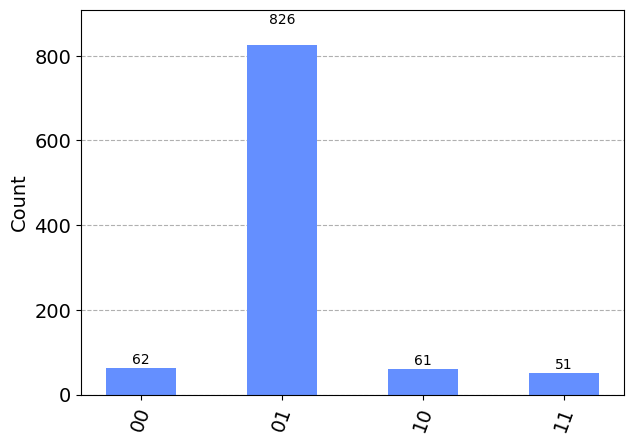

In [233]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, BasicAer
from qiskit.visualization import plot_histogram, array_to_latex
from qiskit.quantum_info import Statevector
import numpy as np
backend = BasicAer.get_backend('qasm_simulator')

def add_cry(c, theta, x, y):
    c.ry(theta/2, y)
    c.cx(x, y)
    c.ry(-theta/2, y)
    c.cx(x, y)
    
def add_ccx(c, x, y, z):
    add_cry(c, np.pi/2, y, z)
    c.cx(x, y)
    add_cry(c, -np.pi/2, y, z)
    c.cx(x, y)
    add_cry(c, np.pi/2, x, z)

def add_ccz(c, x, y, z):
    c.h(z)
    add_ccx(c, x, y, z)
    c.h(z)

q = QuantumRegister(3) # We want 3 qubits
c = ClassicalRegister(2) # and also 2 bits
circuit = QuantumCircuit(q, c) # Sets up the quantum computer, a.k.a. quantum circuit

circuit.h(0)
circuit.h(1)
circuit.h(2)

# Black box that does X on qubit 2 iff qubits 0 and 1 are in the secret state (and leaves/returns them in that state).
# Secret state is |01>, i.e. qubit 0 = |1>, qubit 1 = |0>.
circuit.ry(np.pi, 1)
add_ccx(circuit, 0, 1, 2)
circuit.ry(-np.pi, 1)
#This one works - equivalent to flipping the sign on the |001> row if everything is in equal superposition.
#Also, only swaps to a state in the second half of the state vector if start in |001> row
#circuit.x(1)
#circuit.ccx(0,1,2)
#circuit.x(1)
#v4 = Statevector(circuit)

circuit.h(0)
circuit.h(1)
circuit.h(2)

# Flip the sign on the |000> row:
# Next three lines are equivalent to reversing the state vector
circuit.ry(np.pi,0)
circuit.ry(np.pi,1)
circuit.ry(np.pi,2)
#add_ccz(circuit, 0, 1, 2)
circuit.ccz(2, 1, 0)
# Then we "un-reverse" the state vector
circuit.ry(-np.pi,0)
circuit.ry(-np.pi,1)
circuit.ry(-np.pi,2)

circuit.h(0)
circuit.h(1)
circuit.h(2)

#array_to_latex(np.vstack(v4.data))

circuit.measure(q[0:2], c)          # Measure the two qubits 0 and 1, and get some bits
result = execute(circuit, backend, shots=1000).result()    # Run this all 1,000 times
plot_histogram(result.get_counts(circuit))                 # Show a histogram of the results